### Removing unnecessary columns and apply stopwords and stemming to get important words 
### Get the top 50 repeated words in all the comments and made a word cloud to showcase them
### Used BERT(LLM) to extract features and apply cosine similarity 
### After applying similarity get the 10 least similar words 
### Applying BERT to get features for all the comments  
### Assign each comment to the most similar unique word ON THE BASIS OF SIMILARTY THEY HAVE 
### creating 10 unique labels (tags) for the comments.


In [ ]:
### Try to get the unique disimilar words that are adjectives/verbs/or noun actionalbe words and once we have top 10 of that 
### Get other sub-lables on the basis of those labels which are most similar to them.



## Getting the top10 most unique words

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/5g/_gdkfx8s4nzcbr21_35z4w2w0000gn/T/ipykernel_42111/1228587240.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Code name'] = df['Code name'].fillna("0")
/var/folders/5g/_gdkfx8s4nzcbr21_35z4w2w0000gn/T/ipykernel_42111/1228587240.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

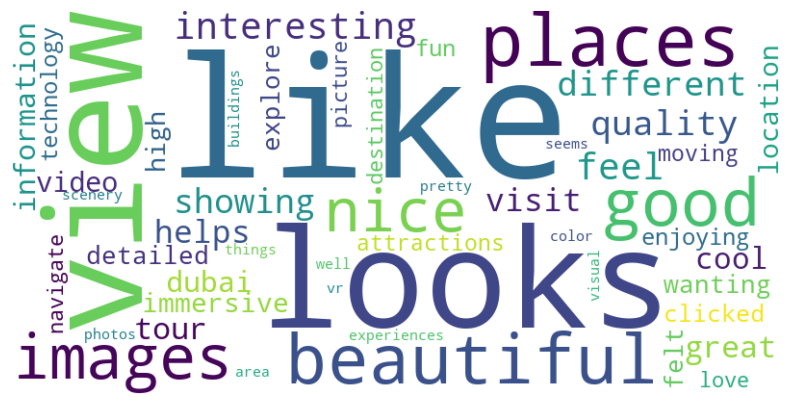

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pyth

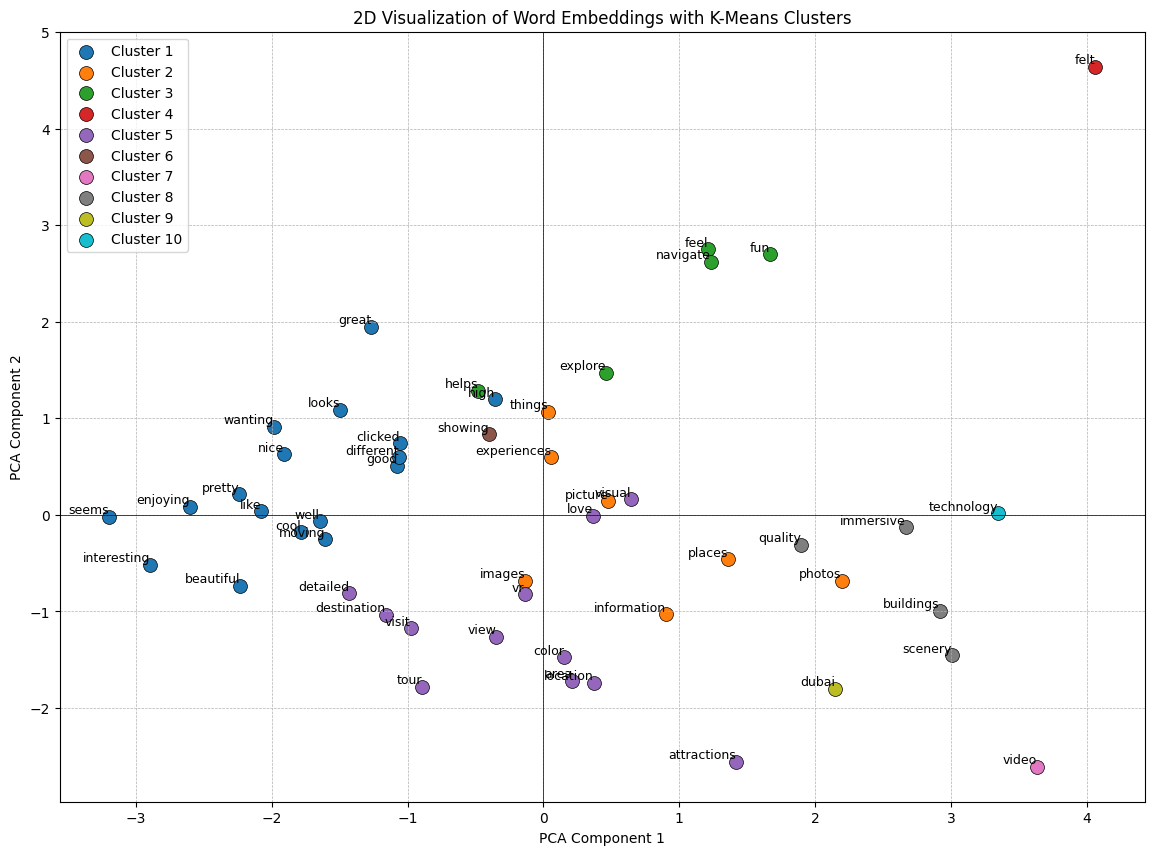

Most dissimilar words from each cluster: [('Cluster 1', 'great'), ('Cluster 2', 'photos'), ('Cluster 3', 'fun'), ('Cluster 4', 'felt'), ('Cluster 5', 'love'), ('Cluster 6', 'showing'), ('Cluster 7', 'video'), ('Cluster 8', 'immersive'), ('Cluster 9', 'dubai'), ('Cluster 10', 'technology')]
Just the list of dissimilar words: ['great', 'photos', 'fun', 'felt', 'love', 'showing', 'video', 'immersive', 'dubai', 'technology']


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
import re
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

def removing_extra_columns(df):  
    selected_columns = ['Order', 'VR quality', 'Code name']
    df = df[selected_columns]
    df['Code name'] = df['Code name'].fillna("0")
    return df


#________________GETTING BERT FEATURES________________

def getting_repeated_words(df):
    df['VR quality'] = df['VR quality'].fillna("")
    comments = ' '.join(df['VR quality'])
    pattern_to_remove = r"\b\w+'\b"  # Corrected pattern to remove words with apostrophes
    all_comments = re.sub(pattern_to_remove, '', comments)
    
    stop_words = set(stopwords.words('english'))
    punctuations = set(string.punctuation)
    stemmer = SnowballStemmer("english")

    stop_words.update(['easy', 'see', "way", 'use', 'clear', 'could', 'able', 'city', 'would', 'lot', 'around', 'get', 'go', 'many', 'making', 'many', "really","actually"])

    filtered_comments = ' '.join([word.lower() for word in all_comments.split() if word.lower() not in stop_words and word.lower() not in punctuations])

    words = filtered_comments.split()

    stem_to_original = {}

    stemmed_words = []
    for word in words:
        stemmed = stemmer.stem(word.lower())
        if stemmed not in stop_words and stemmed not in punctuations:
            stemmed_words.append(stemmed)
            stem_to_original[stemmed] = word.lower()

    word_counts = Counter(stemmed_words)

    # Getting the top 50 most repeated words 
    top_50_words = {stem_to_original[word]: count for word, count in word_counts.most_common(50)}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_50_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return list(top_50_words.keys())


#________________GETTING BERT FEATURES________________

def get_bert_embeddings(sentences):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
    input_ids = []
    attention_masks = []
    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sentence,                      
                            add_special_tokens=True, 
                            max_length=128,           
                            pad_to_max_length=True,
                            return_attention_mask=True,   
                            return_tensors='pt',     
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
    text_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return text_embeddings

#_______________APPLYING PCA_________________

def apply_pca(embeddings):
    pca = PCA(n_components=10)
    data_pca = pca.fit_transform(embeddings)
    pca_2d = PCA(n_components=2)
    embeddings_2d = pca_2d.fit_transform(data_pca)
    return data_pca, embeddings_2d

#_______________APPLYING KMEANS_________________

def kmeans_clustering(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    return kmeans, clusters

#_______________VISUALIZING CLUSTERS_________________

def plot_clusters(embeddings_2d, clusters, top_words_list):
    plt.figure(figsize=(14, 10))
    colors = plt.cm.tab10(np.arange(10))  # Color map for 10 clusters

    for cluster_id in range(10):
        cluster_indices = np.where(clusters == cluster_id)[0]
        plt.scatter(embeddings_2d[cluster_indices, 0], embeddings_2d[cluster_indices, 1], color=colors[cluster_id], label=f'Cluster {cluster_id+1}', edgecolor='black', linewidth=0.5, s=100)
        for idx in cluster_indices:
            plt.text(embeddings_2d[idx, 0], embeddings_2d[idx, 1], top_words_list[idx], fontsize=9, ha='right', va='bottom')

    plt.title('2D Visualization of Word Embeddings with K-Means Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.axvline(x=0, color='k', linewidth=0.5)
    plt.show()
    

#_______________FINDING TOP 10 MOST DISSIMILAR WORDS FROM EACH CLUSTER_________________

def find_most_dissimilar_words_and_clusters(embeddings, words_list, clusters, kmeans):
    most_dissimilar_words_with_clusters = []
    most_dissimilar_words = []
    for cluster_id in range(kmeans.n_clusters):
        # Indices of words in the current cluster
        indices_in_cluster = [i for i, cluster in enumerate(clusters) if cluster == cluster_id]
        
        # Centroid of the current cluster
        centroid = kmeans.cluster_centers_[cluster_id]
        
        # Find the word farthest from the centroid in this cluster
        farthest_distance = -1
        farthest_word_index = None
        for idx in indices_in_cluster:
            distance = np.linalg.norm(embeddings[idx] - centroid)
            if distance > farthest_distance:
                farthest_distance = distance
                farthest_word_index = idx
        
        # Append the cluster name (or ID) and the most dissimilar (farthest) word of this cluster to the list
        cluster_name = f"Cluster {cluster_id+1}"  # Naming clusters as Cluster 1, Cluster 2, etc.
        most_dissimilar_words_with_clusters.append((cluster_name, words_list[farthest_word_index]))
        most_dissimilar_words.append(words_list[farthest_word_index])
    
    return most_dissimilar_words_with_clusters, most_dissimilar_words



# Main code
df = pd.read_csv("data/vr_comments.csv")

top_words_list = getting_repeated_words(removing_extra_columns(df))

word_embeddings = get_bert_embeddings(top_words_list)

reduced_word_embeddings, embeddings_2d = apply_pca(word_embeddings)

kmeans, clusters = kmeans_clustering(reduced_word_embeddings)

plot_clusters(embeddings_2d, clusters, top_words_list)

most_dissimilar_words_with_clusters, most_dissimilar_words = find_most_dissimilar_words_and_clusters(reduced_word_embeddings, top_words_list, clusters, kmeans)
print("Most dissimilar words from each cluster:", most_dissimilar_words_with_clusters)
print("Just the list of dissimilar words:", most_dissimilar_words)


In [2]:
reduced_word_embeddings.shape

(50, 10)

In [3]:
most_dissimilar_words

['great',
 'photos',
 'fun',
 'felt',
 'love',
 'showing',
 'video',
 'immersive',
 'dubai',
 'technology']

In [11]:
most_dissimilar_words
def apply_pca_for_ten(embeddings):
    pca = PCA(n_components=10)
    data_pca = pca.fit_transform(embeddings)
    return data_pca

dissimilar_words_embeddings = get_bert_embeddings(most_dissimilar_words)
reduced_dissimilar_words_embeddings = apply_pca_for_ten(dissimilar_words_embeddings)
reduced_dissimilar_words_embeddings.shape


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(10, 10)

### getting features for all the comments 

In [5]:
all_comments = df['VR quality']
comments_embeddings = get_bert_embeddings(all_comments)
print(comments_embeddings.shape)
print("-------------------")
reduced_comment_embeddings, embeddings_2d = apply_pca(comments_embeddings)
print(reduced_comment_embeddings.shape)
kmeans, clusters = kmeans_clustering(reduced_comment_embeddings)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(1217, 768)
-------------------
(1217, 10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


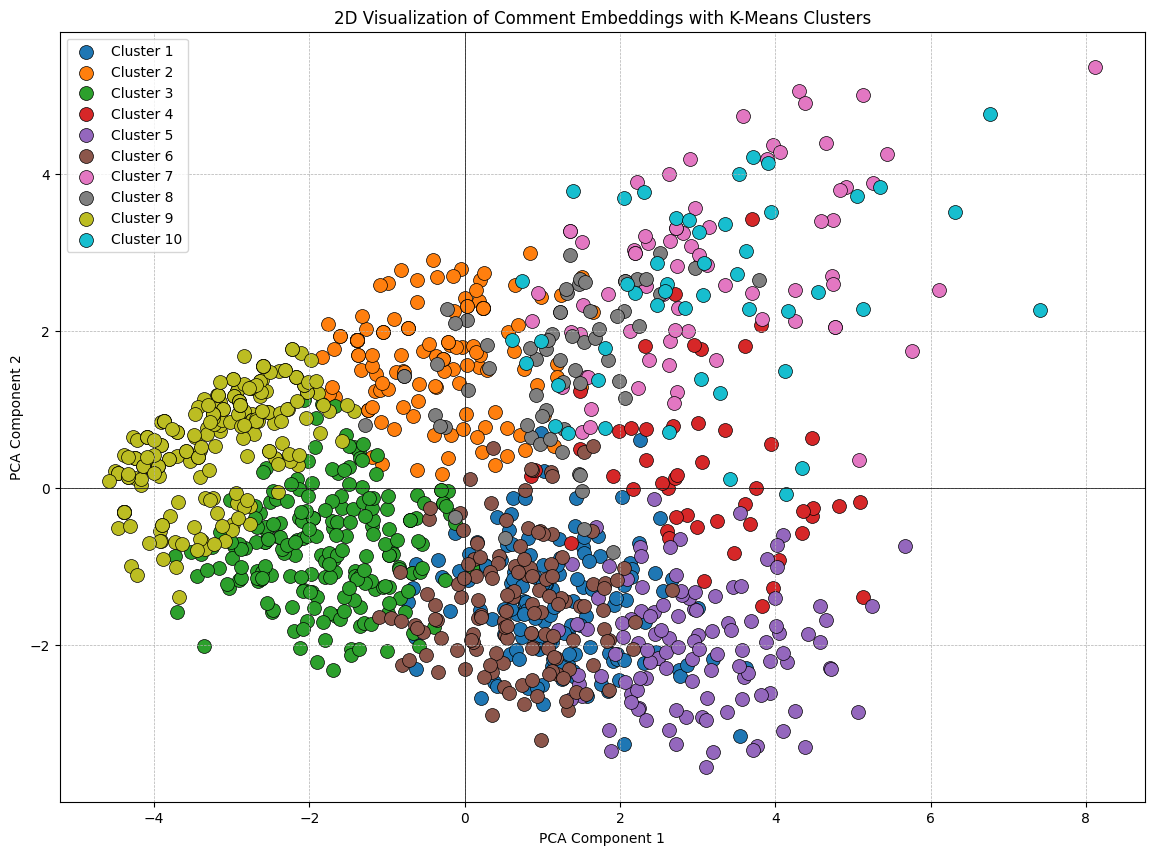

In [6]:
def plot_clusters(embeddings_2d, clusters):
    plt.figure(figsize=(14, 10))
    colors = plt.cm.tab10(np.arange(10))  # Color map for 10 clusters

    for cluster_id in range(10):
        cluster_indices = np.where(clusters == cluster_id)[0]
        plt.scatter(embeddings_2d[cluster_indices, 0], embeddings_2d[cluster_indices, 1], color=colors[cluster_id], label=f'Cluster {cluster_id+1}', edgecolor='black', linewidth=0.5, s=100)

    plt.title('2D Visualization of Comment Embeddings with K-Means Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.axvline(x=0, color='k', linewidth=0.5)
    plt.show()

plot_clusters(embeddings_2d, clusters)

In [ ]:

# Top 10 Unique Words: From BERT
['great',
 'photos',
 'fun',
 'felt',
 'love',
 'showing',
 'video',
 'immersive',
 'dubai',
 'technology']

# 

Top 10 Unique Words: From TFIDF 
['experiences', 'interesting', 
 'information', 'attractions', 'destination', 'technology', 'buildings', 'beautiful', 'immersive', 'different']